<a href="https://colab.research.google.com/github/MarkusThill/techdays25/blob/feature-lab2-initial-draft/notebooks/lab1-my-first-onnx-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Lab 1: Erstelle dein erstes ONNX-Modell Schritt für Schritt
- Dieses Jupyter Notebook benötigt keine GPU Laufzeit. Falls nicht bereits voreingestellt, kann daher der Laufzeittyp im Menü unter "Laufzeit" > "Laufzeittyp ändern" > "Hardwarebeschleuniger" > "CPU" geändert werden!

# Vorbereitungen: Installation der nötigen Abhängigkeiten

In [ ]:
# Remove the `%%capture`, if you have the impression that something is going wrong during the setup
%%capture
!pip install "techdays25[lab1] @ git+https://github.com/MarkusThill/techdays25.git@main"

<font color="red"><b>
⚠️ WICHTIG: Nach der Installation der Abhängigkeiten (siehe oben) muss die Google Colab Laufzeit neugestartet werden (Menü > Laufzeit > Sitzung neu starten)! Im Anschluss kann mit der Ausführung der nächsten Zellen fortgefahren werden werden. ⚠️
</font></b>

In [ ]:
# @title Einige Colab-spezfische Einstellungen {display-mode: "form"}
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import output

    output.enable_custom_widget_manager()

# 🔧 Einführung: Widerstandsschätzung mit Machine Learning

In diesem Lab verbinden wir zwei spannende Welten: **klassische Elektrotechnik** und **moderne Methoden des maschinellen Lernens**. Unser Ziel ist es, ein einfaches physikalisches Problem datengetrieben zu lösen – nicht durch manuelle Berechnung, sondern durch das Training eines Modells.

---

## 🧪 Das Setup: Ein einfacher Stromkreis

Stellen wir uns einen einfachen elektrischen Stromkreis vor, bestehend aus:

- einer **idealen Spannungsquelle**,
- einem unbekannten **Widerstand $R$**,
- einem **Amperemeter** zur Strommessung,
- und einem **Voltmeter** zur Spannungsmessung.

Wenn wir eine Spannung $U$ anlegen, fließt ein Strom $I$ durch den Widerstand. Laut dem **Ohm’schen Gesetz** besteht ein linearer Zusammenhang zwischen Spannung und Strom:

$$
U = R \cdot I
\quad \Rightarrow \quad
I = \frac{1}{R} \cdot U
$$

Solange die Messwerte perfekt sind, genügt eine einfache Division, um $R$ zu bestimmen. In der Praxis jedoch sieht es anders aus.

---

## 🔍 Das Problem: Messfehler und systematischer Stromversatz

In realen Messsituationen sind unsere Daten **nicht perfekt**. Die Spannungs- und Stromwerte, die wir mit unseren Geräten erfassen, sind durch verschiedene Faktoren **verrauscht**:

- Ungenauigkeit der Sensoren
- elektrische Störungen
- Rundungsfehler in der Aufzeichnung

Doch in unserem Szenario gibt es eine weitere, spezielle Herausforderung:

> 🔎 **Der Stromsensor weist einen systematischen Fehler auf** – er misst durchgehend einen zu hohen Stromwert. Dieser konstante Offset führt dazu, dass alle gemessenen Ströme $I_{\text{gemessen}}$ größer sind als der tatsächliche Strom $I_{\text{wahr}}$.

Das bedeutet, dass die Daten verzerrt sind – und dass eine direkte Anwendung des Ohm’schen Gesetzes mit den Messwerten zu falschen Schlüssen führen kann.

---

## 🤖 Die Lösung: Lineares Modell lernen

Hier kommt **maschinelles Lernen** ins Spiel.

Statt auf einzelne Werte zu schauen, nutzen wir statistische Methoden, um **aus einer Vielzahl verrauschter und verzerrter Daten** die zugrunde liegende Beziehung zu lernen. Die Idee:

- Wir betrachten **die Spannung $U$ als Eingabegröße (Feature)**,
- und **den Strom $I_{\text{gemessen}}$ als Zielgröße (Label)**,
- und trainieren ein Modell, das lernt:  
  $$
  I_{\text{gemessen}} \approx m \cdot U + b
  $$

Dabei ist $m$ die geschätzte Steigung.
Der Bias-Term $b$ hilft dabei, den systematischen Stromversatz im Modell zu kompensieren.

> ✅ Mithilfe des gelernten Modells lässt sich der **systematische Offset** sowie eine **Schätzung für den Widerstand** $R$ berechnen. Die Frage wäre, wie?

---

## 🧰 Was wir in diesem Lab machen werden

- Wir simulieren Messdaten $(U, I_{\text{gemessen}})$, wobei die Stromwerte einen konstanten Offset enthalten.
- Wir visualisieren die Daten, um den verzerrten Zusammenhang zu verstehen.
- Wir verwenden verschiedene Werkzeuge wie **scikit-learn**, **PyTorch**, **TensorFlow** und **ONNX**, um ein lineares Regressionsmodell zu trainieren.
- Wir analysieren das Modell und interpretieren die Parameter:
  - Wie gut schätzt das Modell den wahren Widerstand $R$? Wie erhalte ich $R$?
  - Lässt sich der systematische Fehler im Stromsensor berechnen?

---

Die folgenden Abbildung illustriert unseren "Messaufbau":

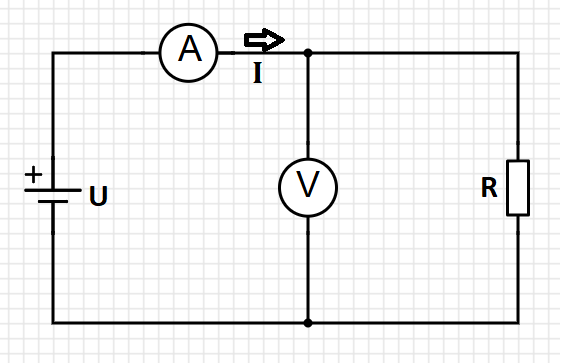

# Datengenerierung

In [ ]:
# Importiere das Modul zur Datengenerierung und generiere einen kleinen 2-dimensionalen Datensatz
from techdays25 import measurement_utils as mu

df = mu.generate_measurement_data()

print("df.shape:", df.shape)

# Zeige die ersten Zeilen des DataFrames an
df.head()

In [ ]:
# @title Visualisierung der generierten Daten {display-mode: "form"}
mu.plot_measurement_data(*df.to_numpy().T)

In [ ]:
# @title Manuelles Einlernen einer linearen Funktion {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt

# set up plot
fig, ax = plt.subplots(figsize=(10, 6))
fig.canvas.toolbar_visible = False
fig.canvas.resizable = False
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.capture_scroll = True
ax.grid(True, which="both")

uu, ii = df.to_numpy().T

ax.scatter(uu, ii)

# plt.minorticks_on()
ax.set_xlabel(r"$U \ [V]$")
ax.set_ylabel(r"$I \ [mA]$")


def linear_func(x, m, b):
    """Return a ..."""
    return m * x + b


(line,) = ax.plot(uu, linear_func(uu, 0, 0), color="black")

dy = linear_func(uu, 0, 0) - ii
residuals_line = ax.vlines(uu, ii, ii + dy, color="darkred")

font = {
    "size": 14,
}
serr = sum(abs(dy) ** 2)
my_textbox = ax.text(
    1, 40, f"Summe der quadrierten Fehler (SSE): {serr: .2f}", fontdict=font
)


@widgets.interact(m=(0, 4, 0.001), b=(-10, 10, 0.001))
def update(m=1.0, b=1.0):
    """Remove old lines from plot and plot new one."""
    line.set_ydata(linear_func(uu, m, b))

    # Update line
    pred = linear_func(uu, m, b)
    dy = pred - ii
    seg = residuals_line.get_segments()
    new_seg = []
    for s, newMin, newMax in zip(seg, pred, pred - dy):
        s[0, -1] = newMin
        s[1, -1] = newMax
        new_seg.append(s)
    residuals_line.set_segments(new_seg)

    # Update text box
    serr = sum(abs(dy) ** 2)
    my_textbox.set_text(f"Summe der quadrierten Fehler (SSE): {serr:.2f}")

    fig.canvas.draw()

# Training unseres ersten Machine-Learning-Modells

## Variante 1: Lineare Regression mit SciKit-Learn und Export nach ONNX
TODO: Explain scikit-learn here:

- Das Scikit-Learn Modell versucht, die Steigung `m` und den Y-Achsenabschnitt (Ordinatenabschnitt) `b` so zu wählen, dass die Summe der quadratischen Fehler minimiert wird

Weitere Details und Beispiele können hier nachgeschlagen werden:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# write the recorded voltages and currents into the two numpy arrays `u` and `i`
uu, ii = df.to_numpy().T

# Note that the input has to be reshaped to a matrix of shape (N, 1)
# since the LinearRegression model is designed to handle multivariate
# regression problems
U = uu.reshape(-1, 1)

# Initialize and train regressor
scikit_regressor = LinearRegression().fit(U, ii)

In [ ]:
# Get the fitted slope `m` and the intercept `b`
scikit_regressor.coef_, scikit_regressor.intercept_

In [ ]:
# Now let us put the original data through the model and plot the obtained predictions:

# put the Nx1-shaped input through the regression model
ii_scikit = scikit_regressor.predict(U)

# Plot the predicted line
mu.plot_measurement_data(
    uu,
    ii,
    ii_scikit,
    title="Original Data & Predictions by Scikit-Learn",
)

### Fragen/Zusatzaufgaben (Optional)
1. Stimmen die durch Scikit-Learn ermittelten Parameter `regressor.coef_, regressor.intercept_` in etwa mit den Werten `m` und `b` überein, die ihr im interaktivem Widget weiter oben ermittelt habt?
2. Könnt ihr die Summe der quadratischen Abweichungen (SSE) für das scikit-learn-Model bestimmen und vergleichen mit dem SSE den ihr manuell erzielt habt?
2. Wie könnten wir überprüfen, ob die ermittelten Parameter `m`, `b` schlüssig sind?
3. Könnt ihr für 5 neue beliebige Inputs ($U [V]$) auch die zugehörigen Ströme ($I [mA]$) prognostizieren und plotten?

### Export des scikit-learn Modells nach ONNX
TODO: Beschreibung

In [ ]:
from pathlib import Path

import onnx
import skl2onnx
from skl2onnx.common.data_types import FloatTensorType

# Define the initial type for the model's input
initial_type = [("float_input", FloatTensorType([None, U.shape[1]]))]

# Convert the model
onnx_model = skl2onnx.convert_sklearn(scikit_regressor, initial_types=initial_type)

# Save the ONNX model to a file
Path("sklearn_regression.onnx").write_bytes(onnx_model.SerializeToString())

# Load the ONNX model
onnx_model = onnx.load("sklearn_regression.onnx")

# Check the model
onnx.checker.check_model(onnx_model)

# Print a human-readable representation of the model
print(onnx.helper.printable_graph(onnx_model.graph))

#### Visualisierung des ONNX-Graphen mit Netron
- ONNX-Modelle können auf [https://netron.app/](https://netron.app/) visualisiert werden
- Alternativ lässt sich auch das `netron` Python Package in Google Colab nutzen (siehe unten)

In [ ]:
from techdays25 import onnx_utils

onnx_utils.netron_visualize("sklearn_regression.onnx")

## Variante 2: Training eines PyTorch Modells und Export nach ONNX
- TODO: Kurze Beschreibung von PyTorch

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


# Define the model
class SimpleLinearModel(nn.Module):
    """A simple linear regression model.

    This model consists of a single linear layer with one input and one output. It is used
    for simple linear regression tasks where the relationship between the input and output
    is assumed to be linear.
    """

    def __init__(self):
        """Initialize the SimpleLinearModel.

        This model consists of a single linear layer with one input and one output.
        """
        super().__init__()
        # Define a single linear layer with 1 input and 1 output
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        """Perform a forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1) after applying the linear layer.
        """
        # Forward pass: compute the output of the linear layer
        return self.linear(x)

In [ ]:
# Instantiate the model
pytorch_regressor = SimpleLinearModel()
print(pytorch_regressor)  # Print the model architecture

In [ ]:
# Lets get our original dataset again:
uu, ii = df.to_numpy(dtype=np.float32).T

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.SGD(
    pytorch_regressor.parameters(), lr=0.01
)  # Stochastic Gradient Descent optimizer with learning rate 0.01


# Convert data to PyTorch tensors
u_tensor = torch.from_numpy(uu.reshape(-1, 1))
i_tensor = torch.from_numpy(ii.reshape(-1, 1))

# Train the model
num_epochs = 50  # Number of epochs to train

for epoch in range(num_epochs):
    # In practice this is usually not done, but train on the overall dataset
    # here.

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass: compute the model output for the batch
    outputs = pytorch_regressor(u_tensor)

    # Compute the loss
    loss = criterion(outputs, i_tensor)

    # Backward pass: compute the gradients
    loss.backward()

    # Update the model parameters
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], MSE Loss: {loss.item():.4f}, SSE Loss: {loss.item() * i_tensor.shape[0]:.2f}"
        )

In [ ]:
# Accessing the trained parameters
print("Trained parameters (state_dict):")
for param_tensor in pytorch_regressor.state_dict():
    print(f"{param_tensor}: {pytorch_regressor.state_dict()[param_tensor].numpy()}")

# Extract specific parameters
weights = pytorch_regressor.linear.weight.data.numpy()
bias = pytorch_regressor.linear.bias.data.numpy()

print("\nExtracted parameters:")
print(f"Weights: {weights}")
print(f"Bias: {bias}")

In [ ]:
# Get the model's predictions and plot
with torch.no_grad():  # Disable gradient computation for inference
    ii_pytorch = (
        pytorch_regressor(u_tensor).numpy().flatten()
    )  # Get the predictions and convert to NumPy array

sse_torch = mu.sse(ii, ii_pytorch)
sse_scikit = mu.sse(ii, ii_scikit)
mu.plot_measurement_data(
    uu.flatten(),
    ii.flatten(),
    {"torch": ii_pytorch, "scikit-learn": ii_scikit},
    title=f"Original data & predictions by the PyTorch (SSE=${sse_torch:.2f}$) and scikit-learn models (SSE=${sse_scikit:.2f}$)",
)

### Fragen/Zusatzaufgaben (Optional):
1. Woran könnte es liegen, dass die Geraden (Prognosen) für "pytorch" und "scikit-learn" nicht übereinstimmen?
2. Wie könnte man das ausgemachte Problem aus 1. beheben?

### Export des PyTorch Modells nach ONNX

In [ ]:
# Export the model to ONNX
# Create a dummy input tensor with the same shape as the model input
dummy_input = torch.randn(1, 1)

# Specify the path where the ONNX file will be saved
onnx_file_path = "pytorch_regression.onnx"

# Export the model to ONNX format
torch.onnx.export(
    pytorch_regressor,  # The trained PyTorch model to be exported
    dummy_input,  # A dummy input tensor to trace the model
    onnx_file_path,  # The path where the ONNX file will be saved
    input_names=["input"],  # A list of input names for the ONNX model
    output_names=["output"],  # A list of output names for the ONNX model
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"},
    },  # Specify which axes are dynamic (e.g., batch size)
)

# Print a confirmation message
print(f"Model has been converted to ONNX and saved at {onnx_file_path}")

#### Visualisierung des PyTorch-exportierten ONNX-Graphen mit Netron

In [ ]:
from techdays25 import onnx_utils

onnx_utils.netron_visualize("pytorch_regression.onnx")

#### Fragen/Zusatzaufgaben (Optional)
1. Inwieweit unterscheidet sich das obige ONNX-Modell von dem ONNX-Modell das wir aus scikit-learn exportiert haben?
2. Was verbirgt sich hinter der Operation im obigen Graphen? Hinweis: In den "Node Properties" kann beispielsweise für das Feld "type" ein Hilfefenster angezeigt werden.

## Variante 3 (Optional): Training eines Keras/Tensorflow Modells und Export nach ONNX

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Define the model
keras_regressor = keras.models.Sequential()
keras_regressor.add(keras.layers.Input(shape=(1,), dtype=tf.float32))
keras_regressor.add(
    keras.layers.Dense(1, activation="linear")
)  # A single neuron with linear activation

# Compile the model
keras_regressor.compile(optimizer="sgd", loss="mse")
keras_regressor.summary()

In [ ]:
# Train the model
uu, ii = df.to_numpy().T
history = keras_regressor.fit(uu, ii, epochs=200, batch_size=20, verbose=0)

# Get model weights
weights = keras_regressor.get_weights()

# weights[0] contains the weights of the Dense layer
# weights[1] contains the bias of the Dense layer
print("Weights:", weights[0])
print("Bias:", weights[1])

In [ ]:
# Get the model's predictions
ii_keras = keras_regressor.predict(uu).flatten()

In [ ]:
sse_torch = mu.sse(ii, ii_pytorch)
sse_scikit = mu.sse(ii, ii_scikit)
sse_keras = mu.sse(ii, ii_keras)

mu.plot_measurement_data(
    uu.flatten(),
    ii.flatten(),
    {"keras": ii_keras, "torch": ii_pytorch, "scikit-learn": ii_scikit},
    title=f"Keras (SSE=${sse_keras:.2f}$), PyTorch (SSE=${sse_torch:.2f}$) & Scikit-Learn (SSE=${sse_scikit:.2f}$) im Vergleich",
)

### Export des Keras Modells nach ONNX

In [ ]:
import tf2onnx

# Diese Zelle könnte einen Fehler werfen.
# Dennoch sollte das ONNX Modell korrekt exportiert werden
keras_regressor.output_names = ["output"]

input_signature = [tf.TensorSpec([None, 1], tf.float32, name="u")]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(keras_regressor, input_signature, opset=18)
onnx.save(onnx_model, "keras_regression.onnx")

In [ ]:
from techdays25 import onnx_utils

onnx_utils.netron_visualize("keras_regression.onnx")

## Variante 4 (Optional): Wir "trainieren" und exportieren das Modell selbst

TODO: Einleitung hier:

Es kann gezeigt werden, dass folgende Lösung tatsächlich der "Methode der kleinsten Quadrate" entspricht:
\begin{align}
\mathbf{i}&= \mathbf{U}\mathbf{w} \\
\mathbf{U}^\mathsf{T}\mathbf{i} &= \mathbf{U}^\mathsf{T}\mathbf{U}\mathbf{w} \\
(\mathbf{U}^\mathsf{T}\mathbf{U})^{-1}\mathbf{U}^\mathsf{T}\mathbf{i} &= (\mathbf{U}^\mathsf{T}\mathbf{U})^{-1} \mathbf{U}^\mathsf{T}\mathbf{U}\mathbf{w} \\
\mathbf{w} &= (\mathbf{U}^\mathsf{T}\mathbf{U})^{-1}\mathbf{U}^\mathsf{T}\mathbf{i} \\
\end{align}

In [ ]:
import sympy

# Lets get our original dataset again:
uu, ii = df.to_numpy().T

U = np.stack([uu, np.ones(len(uu))]).T
sympy.Matrix(U[:7])

In [ ]:
weight, bias = np.linalg.inv(U.T @ U) @ U.T @ ii
print(f"weight: {weight}, bias: {bias}")

### Export mit 'onnx.parser'

In [ ]:
from onnx import helper, parser

graph_str = f"""
agraph (float[N, 2] X) => (float[N, 1] Y_pred)
{{
    W = Constant <value = float[2,1] {{ {weight}, {bias} }}> ()
    Y_pred = MatMul(X,W)
}}
"""

graph = parser.parse_graph(graph_str)
model = helper.make_model(graph, producer_name="onnx-agraph")
onnx.save(model, "parsedgraph_regression.onnx")

In [ ]:
from techdays25 import onnx_utils

onnx_utils.netron_visualize("parsedgraph_regression.onnx")

### Export mit ONNX Helper API

In [ ]:
import numpy as np
import onnx
from onnx import TensorProto, helper, numpy_helper

# Define weights
W_array = np.array([[weight], [bias]], dtype=np.float32)
W_tensor = numpy_helper.from_array(W_array, name="W")

# Input and output tensor definitions
X = helper.make_tensor_value_info("X", TensorProto.FLOAT, ["N", 2])
Y_pred = helper.make_tensor_value_info("Y_pred", TensorProto.FLOAT, ["N", 1])

# Constant node for weights
const_node = helper.make_node("Constant", inputs=[], outputs=["W"], value=W_tensor)

# MatMul node
matmul_node = helper.make_node("MatMul", inputs=["X", "W"], outputs=["Y_pred"])

# Create the graph
graph = helper.make_graph(
    nodes=[const_node, matmul_node],
    name="LinearModelGraph",
    inputs=[X],
    outputs=[Y_pred],
    initializer=[],  # Constants are provided via nodes
)

# Create the model
model = helper.make_model(graph, producer_name="onnx-helper-api")
onnx.save(model, "helperapi_regression.onnx")

### Export mit ONNX Script

In [ ]:
import numpy as np
import onnx
from onnx import TensorProto
from onnxscript import FLOAT, script
from onnxscript import opset18 as op


def onnxscript_regression(weight: float, bias: float):
    """Builds a simple ONNX regression model using torchscript.

    Args:
        weight (float): slope of the linear function
        bias (float): offset of the linear function

    Returns:
        _type_: _description_
    """

    @script()
    def linear_model(x_mat: FLOAT[...]):
        W = op.Constant(
            value=onnx.helper.make_tensor(
                name="W",
                data_type=TensorProto.FLOAT,
                dims=[2, 1],
                vals=[weight, bias],
            )
        )
        return op.MatMul(x_mat, W)

    return linear_model.to_model_proto()


onnx.save(onnxscript_regression(weight, bias), "onnxscript_regression.onnx")

In [ ]:
onnx_utils.netron_visualize("onnxscript_regression.onnx")

## Inferenz mit den ONNX Modellen

In [ ]:
import onnxruntime as ort

# Load the ONNX model
# Specify the path to the ONNX model file
onnx_model_path = "helperapi_regression.onnx"  # TODO: Namen des Modells hier eintragen

# Create an InferenceSession to load the model
session = ort.InferenceSession(onnx_model_path)

# Example input data (make sure it matches the input shape expected by the model)
# Let us create some new input data. Here, we create a NumPy array with shape
# (10, 1) representing 10 samples with 1 feature (voltage) each.
# We sample 10 equidistant points between 0 and 15.
U_new = np.stack([uu, np.ones(len(uu))]).T.astype(dtype=np.float32)

# Get the name of the input node
# The model may have multiple inputs, but we usually need the first one
input_name = session.get_inputs()[0].name

# Get the name of the output node
# Similarly, the model may have multiple outputs, but we usually need the first one
output_name = session.get_outputs()[0].name

# Run inference
# The run method takes a list of output node names and a dictionary mapping input node names to input data
# It returns a list of outputs corresponding to the output node names provided

ii_onnx = session.run([output_name], {input_name: U_new})[0]

# Plot the predictions
# The predictions are returned as a list of NumPy arrays, so we print the first (and only) element
mu.plot_measurement_data(
    uu,
    ii,
    ii_onnx,
    xx_pred=None,
    title=f"Original data & predictions by the ONNX model '{onnx_model_path}'",
)

#### Fragen/Zusatzaufgaben (Optional)
1. Was passiert in obigem Beispiel wenn wir in der Zeile
   `U_new = np.stack([uu, np.ones(len(uu))]).T.astype(dtype=np.float32)`
   das Argument `dtype=np.float32` ersetzen durch `dtype=np.float64`?
2. Wie genau stimmen die Prognosen des ONNX-Modells (von scikit-learn exportiert) mit denen des originalen Modells (z.B., das ursprüngliche scikit-learn Modell) überein? Evaluiere hierzu beide Modelle auf jeweils denselben Input-Daten (entweder die bereits vorhanden Daten oder beispielsweise neu erzeugte (zufällige) Daten für die Spannung $U [V]$.)
